# Automatic program Repair (APR)

In [1]:

import sys

import os
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_loader.loader import load_buggy_dataset, load_data
from bug_detective.detective import process_prompt_dataset

# Add the data_loader module to the path

# Import data loader functions

# Load sample train data
print("Loading sample train data...")

# Load buggy train dataset
buggy_train_df = load_buggy_dataset('train')


Loading sample train data...


In [13]:
# Create a unique ID based on function_name, filename, and url
buggy_train_df['id'] = buggy_train_df.apply(
    lambda row: hash((row['function_name'], row['filename'], row['url'])), 
    axis=1
)

# Convert to string and ensure uniqueness
buggy_train_df['id'] = buggy_train_df['id'].astype(str)

print(f"Created unique ID column. Shape: {buggy_train_df.shape}")
print(f"Number of unique IDs: {buggy_train_df['id'].nunique()}")
print(f"Total rows: {len(buggy_train_df)}")


Created unique ID column. Shape: (14118, 17)
Number of unique IDs: 13777
Total rows: 14118


In [37]:
# Check for rows with repeating id column
duplicate_ids = buggy_train_df[buggy_train_df.duplicated(subset=['id'], keep=False)]
print(f"Found {len(duplicate_ids)} rows with duplicate IDs")
print(f"Number of unique duplicate IDs: {duplicate_ids['id'].nunique()}")

# Display the first few rows with duplicate IDs
test_df =duplicate_ids[duplicate_ids['id'] == '3327769774376610081']


Found 666 rows with duplicate IDs
Number of unique duplicate IDs: 325


In [36]:
# duplicate_ids['id'].tolist()

In [38]:
print(test_df['before_merge_without_docstrings'].iloc[0])

    def append_header(self, name, value):
        
        name, value = self._encode_header(name, value)

        name = name.lower()
        if name in self._headers:
            value = self._headers[name] + ',' + value

        self._headers[name] = value


In [39]:
print(test_df['before_merge_without_docstrings'].iloc[1])

    def append_header(self, name, value):
        
        name = name.lower()
        if name in self._headers:
            value = self._headers[name] + ',' + value

        self._headers[name] = value


In [32]:
test_df.drop_duplicates(subset=['before_merge_without_docstrings'], keep='first')

,after_merge,before_merge,filename,full_file_code_after_merge,full_file_code_before_merge,function_name,url,source code and errors,full_traceback,traceback_type,before_merge_without_docstrings,after_merge_without_docstrings,before_merge_docstrings,after_merge_docstrings,path_to_snippet_before_merge,path_to_snippet_after_merge,id
32216,"def set_header(self, name, value):\n ...","def set_header(self, name, value):\n ...",falcon/response.py,"# Copyright 2013 by Rackspace Hosting, Inc.\n#...","# Copyright 2013 by Rackspace Hosting, Inc.\n#...",Response.set_header,https://github.com/falconry/falcon/issues/413,"[{'piece_type': 'source code', 'piece_content'...","Traceback (most recent call last):\nFile ""/Use...",TypeError,"def set_header(self, name, value):\n ...","def set_header(self, name, value):\n ...",[],[],buggy_snippets_files/45e17bd16b067d758a86afae6...,buggy_snippets_files/45e17bd16b067d758a86afae6...,3947334195646986454
32232,"def set_header(self, name, value):\n ...","def set_header(self, name, value):\n ...",falcon/response.py,"# Copyright 2013 by Rackspace Hosting, Inc.\n#...","# Copyright 2013 by Rackspace Hosting, Inc.\n#...",Response.set_header,https://github.com/falconry/falcon/issues/413,"[{'piece_type': 'source code', 'piece_content'...","Traceback (most recent call last):\nFile ""/Use...",TypeError,"def set_header(self, name, value):\n ...","def set_header(self, name, value):\n ...",[],[],buggy_snippets_files/cd2538f03b06aec1ebbed2243...,buggy_snippets_files/cd2538f03b06aec1ebbed2243...,3947334195646986454


In [2]:

sample_data = buggy_train_df.sample(n=100, random_state=0)
# sample_data = load_data("data_20250703_235942.pkl")
print(f"Sample data shape: {sample_data.shape}")
print(f"Sample data columns: {sample_data.columns.tolist()}")


Sample data shape: (100, 16)
Sample data columns: ['after_merge', 'before_merge', 'filename', 'full_file_code_after_merge', 'full_file_code_before_merge', 'function_name', 'url', 'source code and errors', 'full_traceback', 'traceback_type', 'before_merge_without_docstrings', 'after_merge_without_docstrings', 'before_merge_docstrings', 'after_merge_docstrings', 'path_to_snippet_before_merge', 'path_to_snippet_after_merge']


In [3]:
# Rename the column from qwen_output to response_qwen-2.5-coder-32b-instruct
sample_data = sample_data.rename(columns={'qwen_output': 'response_qwen-2.5-coder-32b-instruct'})
sample_data.head()

,after_merge,before_merge,filename,full_file_code_after_merge,full_file_code_before_merge,function_name,url,source code and errors,full_traceback,traceback_type,before_merge_without_docstrings,after_merge_without_docstrings,before_merge_docstrings,after_merge_docstrings,path_to_snippet_before_merge,path_to_snippet_after_merge
610334,"async def stop_notify(self, _uuid: str) ->...","async def stop_notify(self, _uuid: str) ->...",bleak/backends/bluezdbus/client.py,# -*- coding: utf-8 -*-\nimport logging\nimpor...,# -*- coding: utf-8 -*-\nimport logging\nimpor...,BleakClientBlueZDBus.stop_notify,https://github.com/hbldh/bleak/issues/55,"[{'piece_type': 'error message', 'piece_conten...","Traceback (most recent call last):\nFile ""/hom...",bleak.exc.BleakError,"async def stop_notify(self, _uuid: str) ->...","async def stop_notify(self, _uuid: str) ->...",[],[],buggy_snippets_files/d534f47d51c12cba5c48476b2...,buggy_snippets_files/d534f47d51c12cba5c48476b2...
455757,"def inner(df, func, *args, **kwarg...","def inner(df, func, *args, **kwarg...",tqdm/std.py,"""""""\nCustomisable progressbar decorator for it...","""""""\nCustomisable progressbar decorator for it...",inner_generator.inner,https://github.com/tqdm/tqdm/issues/862,"[{'piece_type': 'source code', 'piece_content'...",----------------------------------------------...,TypeError,"def inner(df, func, *args, **kwarg...","def inner(df, func, *args, **kwarg...",[],[],buggy_snippets_files/3417ddfddae8a2c9079a6fa9a...,buggy_snippets_files/3417ddfddae8a2c9079a6fa9a...
564051,"def post(self, url, data, timeout=None):\n...","def post(self, url, data, timeout=None):\n...",telegram/utils/request.py,#!/usr/bin/env python\n#\n# A library that pro...,#!/usr/bin/env python\n#\n# A library that pro...,Request.post,https://github.com/python-telegram-bot/python-...,"[{'piece_type': 'other', 'piece_content': 'fro...","Traceback (most recent call last):\nFile ""/tmp...",telegram.vendor.ptb_urllib3.urllib3.exceptions...,"def post(self, url, data, timeout=None):\n...","def post(self, url, data, timeout=None):\n...",[],[],buggy_snippets_files/6c268a7167cd7c7691093e131...,buggy_snippets_files/6c268a7167cd7c7691093e131...
47137,def __init__(self):\n app.Canvas.__...,def __init__(self):\n app.Canvas.__...,examples/demo/gloo/realtime_signals.py,#!/usr/bin/env python\n# -*- coding: utf-8 -*-...,#!/usr/bin/env python\n# -*- coding: utf-8 -*-...,Canvas.__init__,https://github.com/vispy/vispy/issues/528,"[{'piece_type': 'error message', 'piece_conten...",cyrille@Cyrille-ASUS:~/git/vispy/examples/demo...,IndexError,def __init__(self):\n app.Canvas.__...,def __init__(self):\n app.Canvas.__...,[],[],buggy_snippets_files/fabf4d259a2e8f6c0999e17b2...,buggy_snippets_files/fabf4d259a2e8f6c0999e17b2...
30127,"def load(tag, creds=None, session_creds=True) ...","def load(tag, creds=None, session_creds=True) ...",hub/collections/dataset/core.py,from collections import abc\nfrom configparser...,from collections import abc\nfrom configparser...,load,https://github.com/activeloopai/Hub/issues/216,"[{'piece_type': 'error message', 'piece_conten...","Traceback (most recent call last):\nFile ""hub/...",ValueError,"def load(tag, creds=None, session_creds=True) ...","def load(tag, creds=None, session_creds=True) ...",[Load a dataset from repository using given ur...,[Load a dataset from repository using given ur...,buggy_snippets_files/c845cb26b5529e8f97a96c5cc...,buggy_snippets_files/c845cb26b5529e8f97a96c5cc...


In [4]:
from llm_models.open_router import create_openrouter_model

qwen_model = create_openrouter_model(
    model_name="qwen/qwen-2.5-coder-32b-instruct",
    temperature=0.0,
    max_tokens=1000
)
gpt_4o_mini_model = create_openrouter_model(
    model_name="openai/gpt-4o-mini",
    temperature=0.0,
    max_tokens=1000
)






In [5]:
outputs_qwen = await process_prompt_dataset(qwen_model, sample_data)
sample_data['response_qwen-2.5-coder-32b-instruct'] = outputs_qwen


Processing sample 100/100: 100%|█████████████████████████████| 100/100 [14:13<00:00,  8.54s/samples]


In [6]:
sample_data.head()

,after_merge,before_merge,filename,full_file_code_after_merge,full_file_code_before_merge,function_name,url,source code and errors,full_traceback,traceback_type,before_merge_without_docstrings,after_merge_without_docstrings,before_merge_docstrings,after_merge_docstrings,path_to_snippet_before_merge,path_to_snippet_after_merge,response_qwen-2.5-coder-32b-instruct
610334,"async def stop_notify(self, _uuid: str) ->...","async def stop_notify(self, _uuid: str) ->...",bleak/backends/bluezdbus/client.py,# -*- coding: utf-8 -*-\nimport logging\nimpor...,# -*- coding: utf-8 -*-\nimport logging\nimpor...,BleakClientBlueZDBus.stop_notify,https://github.com/hbldh/bleak/issues/55,"[{'piece_type': 'error message', 'piece_conten...","Traceback (most recent call last):\nFile ""/hom...",bleak.exc.BleakError,"async def stop_notify(self, _uuid: str) ->...","async def stop_notify(self, _uuid: str) ->...",[],[],buggy_snippets_files/d534f47d51c12cba5c48476b2...,buggy_snippets_files/d534f47d51c12cba5c48476b2...,"async def stop_notify(self, _uuid: str) -> Non..."
455757,"def inner(df, func, *args, **kwarg...","def inner(df, func, *args, **kwarg...",tqdm/std.py,"""""""\nCustomisable progressbar decorator for it...","""""""\nCustomisable progressbar decorator for it...",inner_generator.inner,https://github.com/tqdm/tqdm/issues/862,"[{'piece_type': 'source code', 'piece_content'...",----------------------------------------------...,TypeError,"def inner(df, func, *args, **kwarg...","def inner(df, func, *args, **kwarg...",[],[],buggy_snippets_files/3417ddfddae8a2c9079a6fa9a...,buggy_snippets_files/3417ddfddae8a2c9079a6fa9a...,"def inner(df, func, *args, **kwargs):\n ..."
564051,"def post(self, url, data, timeout=None):\n...","def post(self, url, data, timeout=None):\n...",telegram/utils/request.py,#!/usr/bin/env python\n#\n# A library that pro...,#!/usr/bin/env python\n#\n# A library that pro...,Request.post,https://github.com/python-telegram-bot/python-...,"[{'piece_type': 'other', 'piece_content': 'fro...","Traceback (most recent call last):\nFile ""/tmp...",telegram.vendor.ptb_urllib3.urllib3.exceptions...,"def post(self, url, data, timeout=None):\n...","def post(self, url, data, timeout=None):\n...",[],[],buggy_snippets_files/6c268a7167cd7c7691093e131...,buggy_snippets_files/6c268a7167cd7c7691093e131...,"def post(self, url, data, timeout=None):\n ..."
47137,def __init__(self):\n app.Canvas.__...,def __init__(self):\n app.Canvas.__...,examples/demo/gloo/realtime_signals.py,#!/usr/bin/env python\n# -*- coding: utf-8 -*-...,#!/usr/bin/env python\n# -*- coding: utf-8 -*-...,Canvas.__init__,https://github.com/vispy/vispy/issues/528,"[{'piece_type': 'error message', 'piece_conten...",cyrille@Cyrille-ASUS:~/git/vispy/examples/demo...,IndexError,def __init__(self):\n app.Canvas.__...,def __init__(self):\n app.Canvas.__...,[],[],buggy_snippets_files/fabf4d259a2e8f6c0999e17b2...,buggy_snippets_files/fabf4d259a2e8f6c0999e17b2...,def __init__(self):\n app.Canvas.__init__(s...
30127,"def load(tag, creds=None, session_creds=True) ...","def load(tag, creds=None, session_creds=True) ...",hub/collections/dataset/core.py,from collections import abc\nfrom configparser...,from collections import abc\nfrom configparser...,load,https://github.com/activeloopai/Hub/issues/216,"[{'piece_type': 'error message', 'piece_conten...","Traceback (most recent call last):\nFile ""hub/...",ValueError,"def load(tag, creds=None, session_creds=True) ...","def load(tag, creds=None, session_creds=True) ...",[Load a dataset from repository using given ur...,[Load a dataset from repository using given ur...,buggy_snippets_files/c845cb26b5529e8f97a96c5cc...,buggy_snippets_files/c845cb26b5529e8f97a96c5cc...,"def load(tag, creds=None, session_creds=True) ..."


In [9]:
import pickle
import pandas as pd
from datetime import datetime
from pathlib import Path
import os
data_path = '/Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints'
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
file_name = f'data_{timestamp}'
file_name += '.pkl'
file_path = os.path.join(data_path, file_name)
Path(data_path).mkdir(parents=True, exist_ok=True)
with open(file_path, 'wb') as f:
    pickle.dump(sample_data, f)
print(f"Data saved to: {file_path}")


Data saved to: /Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints/data_20250705_180849.pkl


/var/folders/2p/yszv_4ds72bb4gcspfnbc3vw0000gn/T/ipykernel_5486/3583191427.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([bug_vs_corrected_ast, bug_vs_groundtruth_ast],
/var/folders/2p/yszv_4ds72bb4gcspfnbc3vw0000gn/T/ipykernel_5486/3583191427.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 2].boxplot([bug_vs_corrected_text, bug_vs_groundtruth_text],


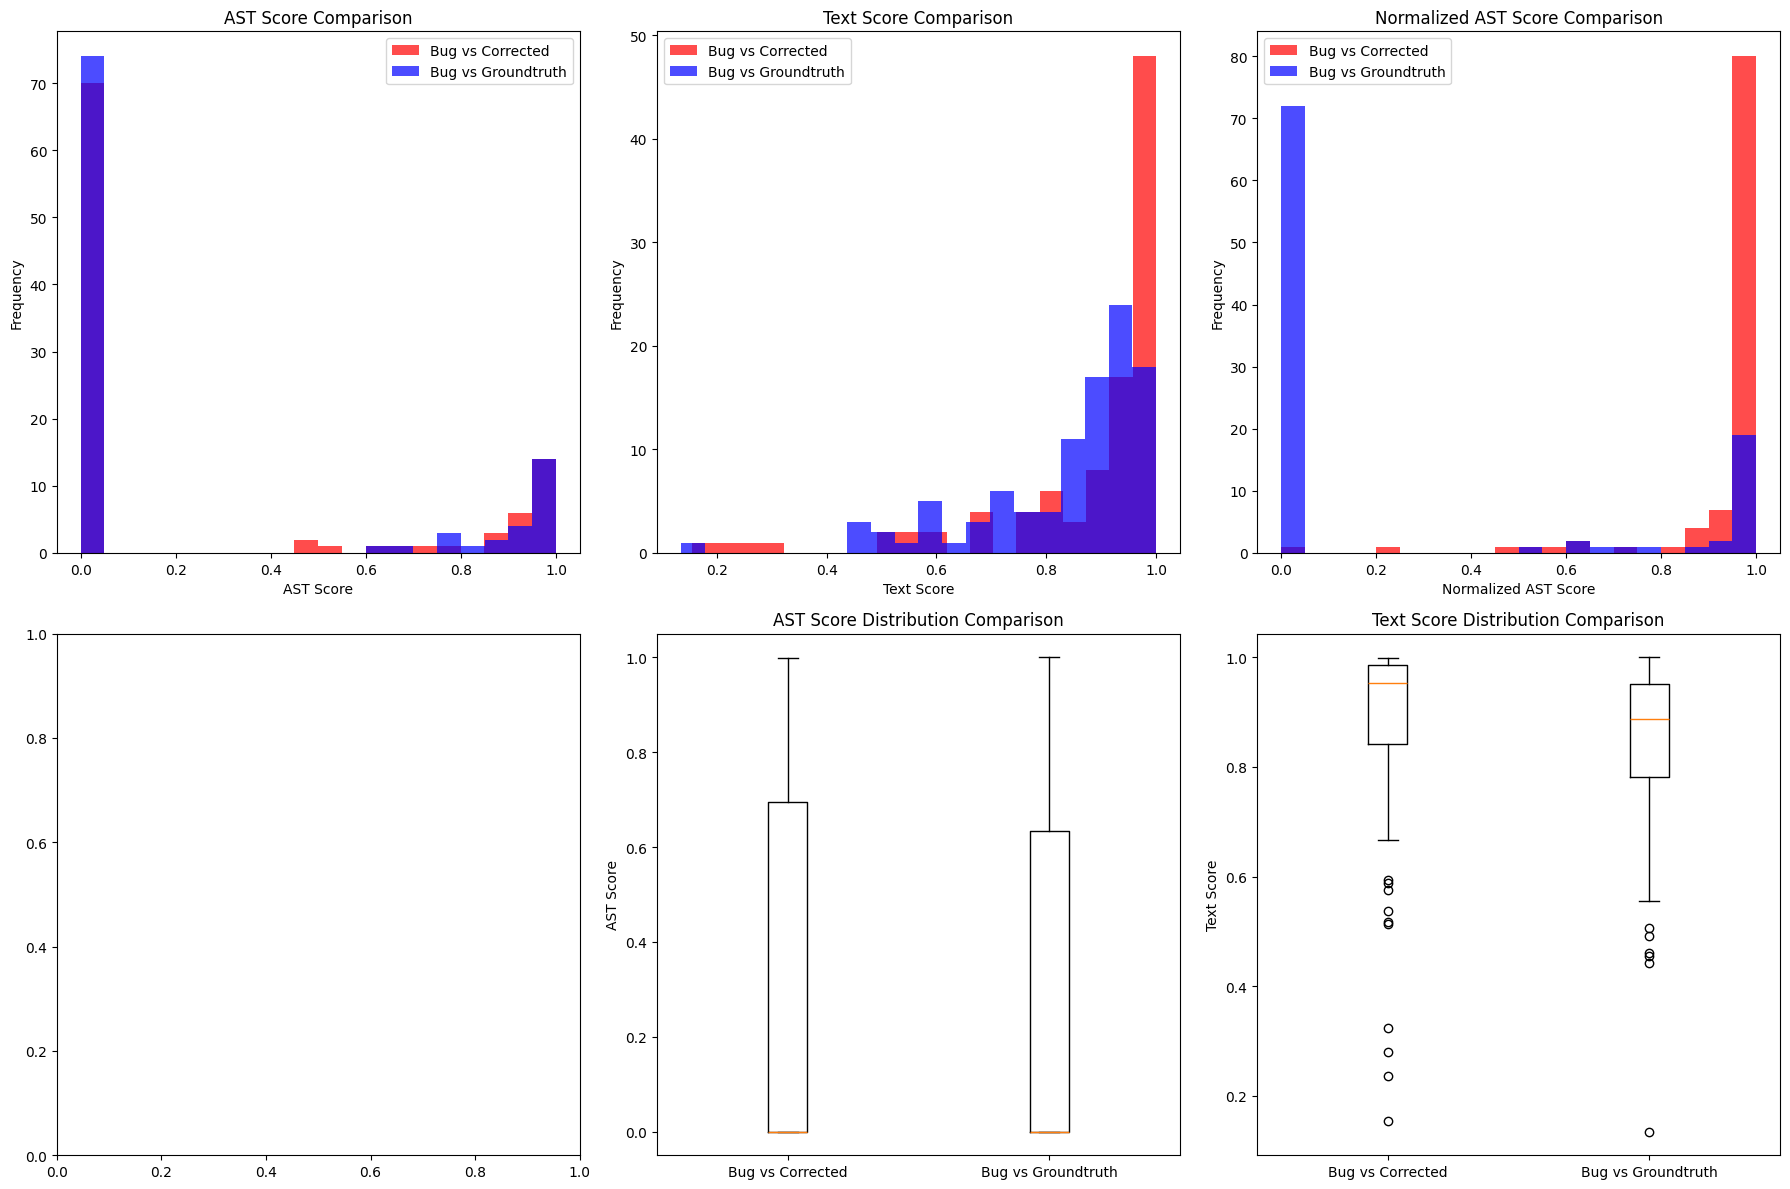

=== DIFF SCORE STATISTICS ===
AST Score - Bug vs Corrected: mean=0.262, std=0.410
AST Score - Bug vs Groundtruth: mean=0.238, std=0.405
Text Score - Bug vs Corrected: mean=0.879, std=0.176
Text Score - Bug vs Groundtruth: mean=0.841, std=0.158
Normalized AST Score - Bug vs Corrected: mean=0.946, std=0.155
Normalized AST Score - Bug vs Groundtruth: mean=0.255, std=0.416


In [8]:
from utils.simple_metrics import diff_score, codebleu
def compare_metrics(buggy_codes, corrected_codes, groundtruth_codes):
    """Compare metrics between buggy, corrected, and groundtruth codes using histograms."""
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Calculate diff scores (returns dict with ast_score, text_score, ast_score_normalized)
    bug_vs_corrected_diff = [diff_score(bug, corr) for bug, corr in zip(buggy_codes, corrected_codes)]
    bug_vs_groundtruth_diff = [diff_score(bug, gt) for bug, gt in zip(buggy_codes, groundtruth_codes)]
    
    # Calculate codebleu scores - updated to handle the new implementation
    # corrected_vs_groundtruth_bleu = [codebleu([corr], [gt]) for corr, gt in zip(corrected_codes, groundtruth_codes)]
    # bug_vs_groundtruth_bleu = [codebleu([bug], [gt]) for bug, gt in zip(buggy_codes, groundtruth_codes)]
    
    # Extract individual diff score components
    bug_vs_corrected_ast = [d['ast_score'] for d in bug_vs_corrected_diff]
    bug_vs_corrected_text = [d['text_score'] for d in bug_vs_corrected_diff]
    bug_vs_corrected_ast_norm = [d['ast_score_normalized'] for d in bug_vs_corrected_diff]
    
    bug_vs_groundtruth_ast = [d['ast_score'] for d in bug_vs_groundtruth_diff]
    bug_vs_groundtruth_text = [d['text_score'] for d in bug_vs_groundtruth_diff]
    bug_vs_groundtruth_ast_norm = [d['ast_score_normalized'] for d in bug_vs_groundtruth_diff]
    
    # Extract CodeBLEU scores from the returned dictionaries
    # corrected_vs_groundtruth_bleu_scores = [score['codebleu'] for score in corrected_vs_groundtruth_bleu]
    # bug_vs_groundtruth_bleu_scores = [score['codebleu'] for score in bug_vs_groundtruth_bleu]
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: AST Score comparisons
    axes[0, 0].hist(bug_vs_corrected_ast, bins=20, alpha=0.7, label='Bug vs Corrected', color='red')
    axes[0, 0].hist(bug_vs_groundtruth_ast, bins=20, alpha=0.7, label='Bug vs Groundtruth', color='blue')
    axes[0, 0].set_xlabel('AST Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('AST Score Comparison')
    axes[0, 0].legend()
    
    # Row 1: Text Score comparisons
    axes[0, 1].hist(bug_vs_corrected_text, bins=20, alpha=0.7, label='Bug vs Corrected', color='red')
    axes[0, 1].hist(bug_vs_groundtruth_text, bins=20, alpha=0.7, label='Bug vs Groundtruth', color='blue')
    axes[0, 1].set_xlabel('Text Score')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Text Score Comparison')
    axes[0, 1].legend()
    
    # Row 1: Normalized AST Score comparisons
    axes[0, 2].hist(bug_vs_corrected_ast_norm, bins=20, alpha=0.7, label='Bug vs Corrected', color='red')
    axes[0, 2].hist(bug_vs_groundtruth_ast_norm, bins=20, alpha=0.7, label='Bug vs Groundtruth', color='blue')
    axes[0, 2].set_xlabel('Normalized AST Score')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Normalized AST Score Comparison')
    axes[0, 2].legend()
    
    # Row 2: CodeBLEU comparisons
    # axes[1, 0].hist(corrected_vs_groundtruth_bleu_scores, bins=20, alpha=0.7, label='Corrected vs Groundtruth', color='green')
    # axes[1, 0].hist(bug_vs_groundtruth_bleu_scores, bins=20, alpha=0.7, label='Bug vs Groundtruth', color='orange')
    # axes[1, 0].set_xlabel('CodeBLEU Score')
    # axes[1, 0].set_ylabel('Frequency')
    # axes[1, 0].set_title('CodeBLEU Score Comparison')
    # axes[1, 0].legend()
    
    # Row 2: Box plot for AST scores
    axes[1, 1].boxplot([bug_vs_corrected_ast, bug_vs_groundtruth_ast], 
                      labels=['Bug vs Corrected', 'Bug vs Groundtruth'])
    axes[1, 1].set_ylabel('AST Score')
    axes[1, 1].set_title('AST Score Distribution Comparison')
    
    # Row 2: Box plot for Text scores
    axes[1, 2].boxplot([bug_vs_corrected_text, bug_vs_groundtruth_text], 
                      labels=['Bug vs Corrected', 'Bug vs Groundtruth'])
    axes[1, 2].set_ylabel('Text Score')
    axes[1, 2].set_title('Text Score Distribution Comparison')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("=== DIFF SCORE STATISTICS ===")
    print(f"AST Score - Bug vs Corrected: mean={np.mean(bug_vs_corrected_ast):.3f}, std={np.std(bug_vs_corrected_ast):.3f}")
    print(f"AST Score - Bug vs Groundtruth: mean={np.mean(bug_vs_groundtruth_ast):.3f}, std={np.std(bug_vs_groundtruth_ast):.3f}")
    print(f"Text Score - Bug vs Corrected: mean={np.mean(bug_vs_corrected_text):.3f}, std={np.std(bug_vs_corrected_text):.3f}")
    print(f"Text Score - Bug vs Groundtruth: mean={np.mean(bug_vs_groundtruth_text):.3f}, std={np.std(bug_vs_groundtruth_text):.3f}")
    print(f"Normalized AST Score - Bug vs Corrected: mean={np.mean(bug_vs_corrected_ast_norm):.3f}, std={np.std(bug_vs_corrected_ast_norm):.3f}")
    print(f"Normalized AST Score - Bug vs Groundtruth: mean={np.mean(bug_vs_groundtruth_ast_norm):.3f}, std={np.std(bug_vs_groundtruth_ast_norm):.3f}")
    
    # print("\n=== CODEBLEU STATISTICS ===")
    # print(f"CodeBLEU - Corrected vs Groundtruth: mean={np.mean(corrected_vs_groundtruth_bleu_scores):.3f}, std={np.std(corrected_vs_groundtruth_bleu_scores):.3f}")
    # print(f"CodeBLEU - Bug vs Groundtruth: mean={np.mean(bug_vs_groundtruth_bleu_scores):.3f}, std={np.std(bug_vs_groundtruth_bleu_scores):.3f}")

# Call the function with the lists
compare_metrics(sample_data['before_merge'],sample_data['after_merge'],sample_data['response_qwen-2.5-coder-32b-instruct'])


In [10]:
codebleu_scores = codebleu(sample_data['before_merge'].tolist(), sample_data['after_merge'].tolist())
print(codebleu_scores)

{'codebleu': 0.8869282094221181, 'ngram_match_score': 0.8967145130610161, 'weighted_ngram_match_score': 0.8972927314768683, 'syntax_match_score': 0.9057125307125307, 'dataflow_match_score': 0.8479930624380575}


In [41]:
check = load_data("data_20250705_180849.pkl")
check.head()

,after_merge,before_merge,filename,full_file_code_after_merge,full_file_code_before_merge,function_name,url,source code and errors,full_traceback,traceback_type,before_merge_without_docstrings,after_merge_without_docstrings,before_merge_docstrings,after_merge_docstrings,path_to_snippet_before_merge,path_to_snippet_after_merge,response_qwen-2.5-coder-32b-instruct
610334,"async def stop_notify(self, _uuid: str) ->...","async def stop_notify(self, _uuid: str) ->...",bleak/backends/bluezdbus/client.py,# -*- coding: utf-8 -*-\nimport logging\nimpor...,# -*- coding: utf-8 -*-\nimport logging\nimpor...,BleakClientBlueZDBus.stop_notify,https://github.com/hbldh/bleak/issues/55,"[{'piece_type': 'error message', 'piece_conten...","Traceback (most recent call last):\nFile ""/hom...",bleak.exc.BleakError,"async def stop_notify(self, _uuid: str) ->...","async def stop_notify(self, _uuid: str) ->...",[],[],buggy_snippets_files/d534f47d51c12cba5c48476b2...,buggy_snippets_files/d534f47d51c12cba5c48476b2...,"async def stop_notify(self, _uuid: str) -> Non..."
455757,"def inner(df, func, *args, **kwarg...","def inner(df, func, *args, **kwarg...",tqdm/std.py,"""""""\nCustomisable progressbar decorator for it...","""""""\nCustomisable progressbar decorator for it...",inner_generator.inner,https://github.com/tqdm/tqdm/issues/862,"[{'piece_type': 'source code', 'piece_content'...",----------------------------------------------...,TypeError,"def inner(df, func, *args, **kwarg...","def inner(df, func, *args, **kwarg...",[],[],buggy_snippets_files/3417ddfddae8a2c9079a6fa9a...,buggy_snippets_files/3417ddfddae8a2c9079a6fa9a...,"def inner(df, func, *args, **kwargs):\n ..."
564051,"def post(self, url, data, timeout=None):\n...","def post(self, url, data, timeout=None):\n...",telegram/utils/request.py,#!/usr/bin/env python\n#\n# A library that pro...,#!/usr/bin/env python\n#\n# A library that pro...,Request.post,https://github.com/python-telegram-bot/python-...,"[{'piece_type': 'other', 'piece_content': 'fro...","Traceback (most recent call last):\nFile ""/tmp...",telegram.vendor.ptb_urllib3.urllib3.exceptions...,"def post(self, url, data, timeout=None):\n...","def post(self, url, data, timeout=None):\n...",[],[],buggy_snippets_files/6c268a7167cd7c7691093e131...,buggy_snippets_files/6c268a7167cd7c7691093e131...,"def post(self, url, data, timeout=None):\n ..."
47137,def __init__(self):\n app.Canvas.__...,def __init__(self):\n app.Canvas.__...,examples/demo/gloo/realtime_signals.py,#!/usr/bin/env python\n# -*- coding: utf-8 -*-...,#!/usr/bin/env python\n# -*- coding: utf-8 -*-...,Canvas.__init__,https://github.com/vispy/vispy/issues/528,"[{'piece_type': 'error message', 'piece_conten...",cyrille@Cyrille-ASUS:~/git/vispy/examples/demo...,IndexError,def __init__(self):\n app.Canvas.__...,def __init__(self):\n app.Canvas.__...,[],[],buggy_snippets_files/fabf4d259a2e8f6c0999e17b2...,buggy_snippets_files/fabf4d259a2e8f6c0999e17b2...,def __init__(self):\n app.Canvas.__init__(s...
30127,"def load(tag, creds=None, session_creds=True) ...","def load(tag, creds=None, session_creds=True) ...",hub/collections/dataset/core.py,from collections import abc\nfrom configparser...,from collections import abc\nfrom configparser...,load,https://github.com/activeloopai/Hub/issues/216,"[{'piece_type': 'error message', 'piece_conten...","Traceback (most recent call last):\nFile ""hub/...",ValueError,"def load(tag, creds=None, session_creds=True) ...","def load(tag, creds=None, session_creds=True) ...",[Load a dataset from repository using given ur...,[Load a dataset from repository using given ur...,buggy_snippets_files/c845cb26b5529e8f97a96c5cc...,buggy_snippets_files/c845cb26b5529e8f97a96c5cc...,"def load(tag, creds=None, session_creds=True) ..."
